In [1]:
import sys
import os

# Get the parent directory of the notebook (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from dotenv import load_dotenv

load_dotenv()

In [2]:
import numpy as np
import tensorflow as tf
import mitsuba as mi
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
import matplotlib.pyplot as plt

In [3]:
scene = load_scene("Blender/maps/polymtl_1/polymtl.xml")

In [4]:
for i, obj in enumerate(scene.objects.values()):
    print(f"Object {i}: {obj.radio_material.name} - {obj.name}")
    if i >= 10:
        break

Object 0: itu_ceiling_board - Agora_Morris-et-Rosalind-Goodman-itu_ceiling_board
Object 1: itu_marble - Agora_Morris-et-Rosalind-Goodman-itu_marble
Object 2: itu_ceiling_board - Agora_Morris-et-Rosalind-Goodman_001-itu_ceiling_board
Object 3: itu_marble - Agora_Morris-et-Rosalind-Goodman_001-itu_marble
Object 4: itu_ceiling_board - Centrale_thermique-itu_ceiling_board
Object 5: itu_marble - Centrale_thermique-itu_marble
Object 6: itu_ceiling_board - Centrale_thermique_001-itu_ceiling_board
Object 7: itu_marble - Centrale_thermique_001-itu_marble
Object 8: itu_ceiling_board - Centre_des_technologies_de_fabrication_en_a_rospatiale-itu_ceiling_board
Object 9: itu_marble - Centre_des_technologies_de_fabrication_en_a_rospatiale-itu_marble
Object 10: itu_ceiling_board - Centre_des_technologies_de_fabrication_en_a_rospatiale_001-itu_ceiling_board


In [5]:
from src.settings.config import num_ut_ant, num_bs_ant
import math

scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1 if num_ut_ant == 1 else int(num_ut_ant // 2),
    polarization_model=1 if num_ut_ant == 1 else 2,
    polarization="V" if num_ut_ant == 1 else "cross",
    pattern="tr38901",
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1 if num_bs_ant == 1 else int(num_bs_ant // 2),
    polarization_model=1 if num_bs_ant == 1 else 2,
    polarization="V" if num_ut_ant == 1 else "cross",
    pattern="tr38901",
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
)

tx = Transmitter("tx", [-28.7637, -79.456, 1.359615], [math.pi / 3, -math.pi / 9, 0])
scene.add(tx)


rx = Receiver("rx", [33.0255, 26.4153, 13.7488], [-math.pi / 1.5, 0, 0])
scene.add(rx)

In [6]:
paths = scene.compute_paths()
a, tau = paths.cir()

In [7]:
tau.shape

TensorShape([1, 1, 1, 30])

In [8]:
a.shape

TensorShape([1, 1, 4, 1, 2, 30, 1])

In [9]:
mask = tf.squeeze(tau != -1.0, axis=[0, 1, 2])  # shape: [27]

# Step 2: Apply mask to tau → output shape [1, 1, 1, m]
tau_filtered = tf.boolean_mask(tau, mask, axis=3)

# Step 3: Apply same mask to dimension 5 of a
a_filtered = tf.boolean_mask(a, mask, axis=5)

Text(0, 0.5, 'Amplitude')

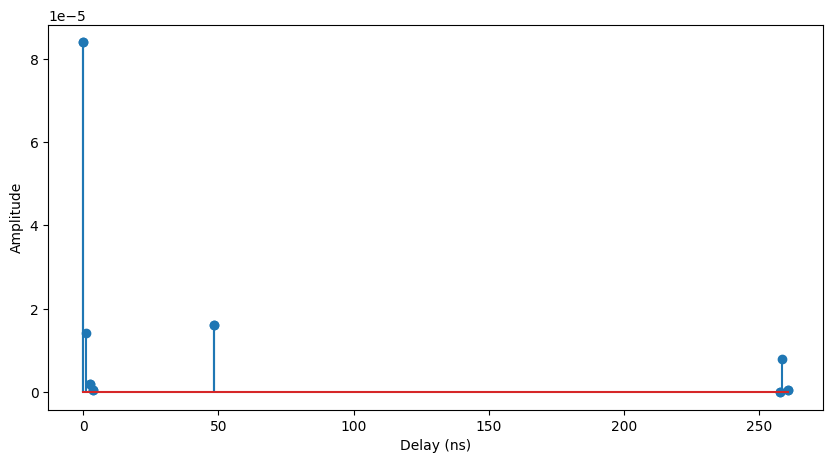

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.stem(tau_filtered[0, 0, 0, :] * 1e9, np.abs(a_filtered[0, 0, 0, 0, 0, :, 0]))
plt.xlabel("Delay (ns)")
plt.ylabel("Amplitude")

In [11]:
# Get positions
tx_pos = tx.position
rx_pos = rx.position
direction = rx_pos - tx_pos

distance = np.linalg.norm(direction)
direction_normalized = direction / distance
direction_normalized

theta = np.arctan2(
    direction_normalized[1], direction_normalized[0]
)  # Azimuth in xy-plane
d = 0.5  # Antenna spacing in wavelengths
steering_vec = np.exp(1j * 2 * np.pi * d * np.arange(num_ut_ant) * np.sin(theta))
precoding_vec = steering_vec / np.linalg.norm(steering_vec)  # Normalize

In [12]:
import tensorflow as tf
import numpy as np


# Compute coverage map
cm = scene.coverage_map(
    max_depth=7,
    diffraction=True,
    cm_cell_size=[1.0, 1.0],
    precoding_vec=precoding_vec,
    num_samples=int(10e6),
)

scene.preview(paths=paths, coverage_map=cm, show_orientations=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [13]:
from src.settings.config import subcarrier_spacing, fft_size, speed
from src.channels.cdl_channel import num_time_steps

paths = scene.compute_paths()
# Apply Doppler shifts
paths.apply_doppler(
    sampling_frequency=subcarrier_spacing,  # Set to 15e3 Hz
    num_time_steps=num_time_steps,  # Number of OFDM symbols
    tx_velocities=[speed, 0, 0],  # We can set additional tx speeds
    rx_velocities=[0, 0, 0],
)  # Or rx speeds

a, tau = paths.cir(los=False)
print("Shape of tau: ", tau.shape)
print("Shape of a: ", a.shape)

Shape of tau:  (1, 1, 1, 30)
Shape of a:  (1, 1, 4, 1, 2, 30, 939)


In [14]:
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies
from src.settings.config import num_subcarrier, cyclic_prefix_length, num_ofdm_symbols


# Compute the channel gain and delays on frequency domain
complex_gain_freq = a[
    ..., cyclic_prefix_length : -1 : (num_subcarrier + cyclic_prefix_length)
]
complex_gain_freq = complex_gain_freq[..., :num_ofdm_symbols]
frequencies = subcarrier_frequencies(num_subcarrier, subcarrier_spacing)


h_freq = cir_to_ofdm_channel(frequencies, complex_gain_freq, tau, normalize=True)

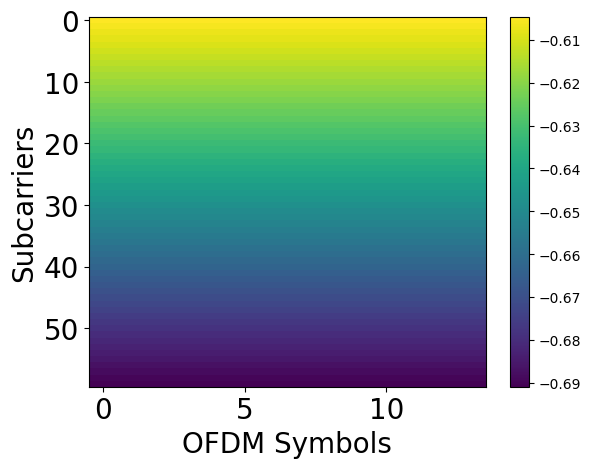

In [15]:
from src.utils.plots import plot_channel_frequency_domain


plot_channel_frequency_domain(
    h_freq[0, 0, 0, 0, 0].numpy().real.T,
)